# Import Libraries

This part of code will import all the necessary libraries required for the code



In this section, we import all the necessary libraries required for building and training the machine learning model. The libraries include custom modules and standard Python packages for data manipulation, geographical computations, and machine learning.

- **pyDTDM.BhuDM**: Custom module for data management and machine learning code used in this project.
- **pyDTDM.utils**: Custom utilities for various functions used in the workflow.
- **warnings**: Module to handle and control warnings during execution.
- **yaml**: Library for parsing YAML files. We use `Cloader` for faster loading if available.
- **ptt**: Custom or third-party module for specific functionalities not detailed here.
- **shapely**: Library for manipulation and analysis of planar geometric objects.
- **pandas**: Library for data manipulation and analysis.
- **geopandas**: Extends pandas to support spatial operations.
- **numpy**: Library for numerical operations and array handling.

In [1]:
from pyDTDM import *
import warnings
import yaml
try:
    from yaml import Cloader as Loader
except ImportError:

    from yaml import Loader

import ptt
import shapely
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

from geopy.distance import geodesic
from geopy import Point as GeopyPoint
import cmcrameri.cm as cmc

# Load Input File

The input file can be changed to include other parameters as well

In [2]:
config_file="InputFiles/phase2NNR_paleotopography.yaml"
with open(config_file) as f:
    PARAMS = yaml.load(f, Loader=Loader)
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(" Parameters set from %s" % config_file)
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")


––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
 Parameters set from InputFiles/phase2NNR_paleotopography.yaml
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 


### Reading the input file

In [29]:
# Input Files 
MODEL_NAME=PARAMS['InputFiles']['plate_kinematics']['model_name'] # model name
MODEL_DIR = PARAMS['InputFiles']['plate_kinematics']['model_dir']  ## plate model location
topology_filenames =[f"{MODEL_DIR}/{i}" for i in PARAMS['InputFiles']['plate_kinematics']['topology_files']]
rotation_filenames = [f"{MODEL_DIR}/{i}" for i in PARAMS['InputFiles']['plate_kinematics']['rotation_files']]
agegrid=PARAMS['InputFiles']['plate_kinematics']['agegrid'] ## agegrid location

ETOPO_FILE=PARAMS['InputFiles']['Raster']['ETOPO_FILE'] # ETOPO grid in meters (can be netCDf or GeoTiff)
ETOPO_Type=PARAMS['InputFiles']['Raster']['Raster_type']
coastlines = f"{MODEL_DIR }/{PARAMS['InputFiles']['plate_kinematics']['coastline_file']}"
static_polygon_file=f"{MODEL_DIR }/{PARAMS['InputFiles']['plate_kinematics']['static_polygon']}"
static_polygons = pygplates.FeatureCollection(static_polygon_file)
continents=f"{MODEL_DIR }/{PARAMS['InputFiles']['plate_kinematics']['continents']}"
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print("Reading input file..... \n")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(f"Plate Model: {MODEL_NAME} \n")
print(f"Model Directory: {MODEL_DIR} \n")
print(f"Coastlines: {coastlines} \n")
print(f"Continents: {continents} \n")
print(f"Static Polygons: {static_polygon_file} \n")
print(f"Model Agegrid: {agegrid} \n")
print(f"ETopo grid: {ETOPO_FILE}")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– \n")

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
Reading input file..... 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
Plate Model: phase2NNR 

Model Directory: /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/BhuDM/Zahirovic_etal_2022_GDJ_NNR 

Coastlines: /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/BhuDM/Zahirovic_etal_2022_GDJ_NNR/StaticGeometries/Coastlines/Global_coastlines_low_res.shp 

Continents: /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/BhuDM/Zahirovic_etal_2022_GDJ_NNR/StaticGeometries/ContinentalPolygons/Global_EarthByte_GPlates_PresentDay_ContinentalPolygons.shp 

Static Polygons: /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/BhuDM/Zahirovic_etal_2022_GDJ_NNR/StaticGeometries/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons.shp 

Model Agegrid: /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/BhuDM/SeafloorAgegrid 

ETopo grid

### Setting model parameters

In [30]:
Paleomag_ID=PARAMS['Parameters']['paleomag_id']
Mantle_ID=PARAMS['Parameters']['mantle_optimised_id']

#The initial positions of crustal points are evenly distributed within the designated region. 
# At mesh refinement level zero, the points are approximately 20 degrees apart.
# Each increase in the density level results in a halving of the spacing between points.
MESH_REFINEMENT_LEVEL=PARAMS['Parameters']['mesh_refinement_level']  # higher refinement level will take longer time to run for optimisation 
WINDOW_SIZE=int(PARAMS['Parameters']['time_window_size'])
Weighted=PARAMS['Parameters']['weighted_mean']


NETCDF_GRID_RESOLUTION=PARAMS['GridParameters']['grid_spacing']  # in degree
ZLIB=PARAMS['GridParameters']['compression']['zlib'] 
COMPLEVEL=PARAMS['GridParameters']['compression']['complevel'] 

FROM_TIME=int(PARAMS['TimeParameters']['time_max'])
TO_TIME=int(PARAMS['TimeParameters']['time_min'])
TIME_STEPS=int(PARAMS['TimeParameters']['time_step'])




parallel=PARAMS['Parameters']['number_of_cpus']### No of core to use or None for single core


print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print("The following parameters are set-")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(f"Mantle Optmised Reference Frame ID: {Mantle_ID}")
print(f"Paleomagnetic Reference Frame ID: {Paleomag_ID} \n")

print(f"Moving Window Size: {WINDOW_SIZE}")
print(f"Weighted Mean: {Weighted}")

print(f"Mesh Refinement Level: {MESH_REFINEMENT_LEVEL}")
print(f"NetCDF GRID Resolution: {NETCDF_GRID_RESOLUTION}")
print(f"NetCDF Compression Level: {COMPLEVEL} \n")
print(f"Model Start Time: {FROM_TIME}")
print(f"Model End Time: {TO_TIME}")
print(f"Model Time Step: {TIME_STEPS}\n")


print(f"Number of CPU: {parallel}") # -1 means all the freely available CPU


print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
The following parameters are set-
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
Mantle Optmised Reference Frame ID: 666666
Paleomagnetic Reference Frame ID: 0 

Moving Window Size: 25
Weighted Mean: True
Mesh Refinement Level: 9
NetCDF GRID Resolution: 0.1
NetCDF Compression Level: 5 

Model Start Time: 10
Model End Time: 0
Model Time Step: 1

Number of CPU: -1
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 


### Creating Output File

The output will be stored in the output folder: Paleotopography

There will be two folder:
- CSV Folder: to store data in tabular format. Here I have used paraquet file because it reduces the storage 
- NetCDF Folder: to store final NetCDF that can be visualised in GPlates


In [31]:
# Output Directory
OUTPUT_FOLDER=PARAMS['OutputFiles']['output_dir']

DEFAULT_OUTPUT_CSV=os.path.join(OUTPUT_FOLDER,'CSV')  # folder to store output in Tabular format
DEFAULT_OUTPUT_NetCDF=os.path.join(OUTPUT_FOLDER,'NetCDF') # folder to store output NetCDF grid





print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(f"All the output will be saved in {OUTPUT_FOLDER}")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
create_directory_if_not_exists(OUTPUT_FOLDER)
create_directory_if_not_exists(DEFAULT_OUTPUT_CSV)
create_directory_if_not_exists(DEFAULT_OUTPUT_NetCDF)
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")


––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
All the output will be saved in /Volumes/Satyam/BHPDryRun
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 


# Define Plate Reconstruction

class PlateKinematicsParameters can be used to define plate kinematics parameters. To know more about class you can use `help` functions. For e.g. help(PlateKinematicsParameters) 

In [32]:

PK=PlateKinematicsParameters(topology_filenames, ## all the plate topologies files (as list of str)
                             rotation_filenames, ### all the rotation files (as list of str)
                             static_polygons,  ### as str
                             agegrid=agegrid,  ### folder containing all the agegrid (as .nc)
                             coastlines=coastlines, ## str
                             continents=continents, ## st
                             anchor_plate_id=Mantle_ID) ## int



RotationModel: No filename associated with <class 'pygplates.pygplates.RotationModel'> in __init__
 ensure pygplates is imported from gplately. Run,
 from gplately import pygplates


In [7]:
time = 0 #Ma
gplot = gplately.PlotTopologies(PK.model, coastlines=coastlines, continents=continents, time=time) ##gplately plotting object


# Tessellate Subduction Zone and fetch associated parameters

This section of the code tessellates all the subduction zones in point and calculates all the associated subduction parameters using  PlateKinematicsParameters.get_subductiondf() function. All these are saved as parquet file.So you don't need to run this block again and again

In [15]:
## uses GPlately at backend to calculate all the plate kinematics related parameters

list_subduction_df=[]
for reconstruction_time in range (TO_TIME,FROM_TIME+WINDOW_SIZE+1):
    if reconstruction_time%50==0:
        print(f"Tessellating Subduction at time= {reconstruction_time} Ma")
    
    subduction_df=PK.get_subductiondf(reconstruction_time,  
                                      tessellation_threshold_deg=NETCDF_GRID_RESOLUTION,
                                      velocity_delta_time=TIME_STEPS)
    subduction_df["Time"]=reconstruction_time
    list_subduction_df.append(subduction_df)

all_sz_df=pd.concat(list_subduction_df)
all_sz_df.to_parquet(f"{DEFAULT_OUTPUT_CSV}/ALL_Subduction.paraquet")

Tessellating Subduction at time= 0 Ma
Using agegrid file : /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/BhuDM/SeafloorAgegrid/agegrid_final_mask_0.0Ma.nc
Using agegrid file : /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/BhuDM/SeafloorAgegrid/agegrid_final_mask_1.0Ma.nc
Using agegrid file : /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/BhuDM/SeafloorAgegrid/agegrid_final_mask_2.0Ma.nc
Using agegrid file : /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/BhuDM/SeafloorAgegrid/agegrid_final_mask_3.0Ma.nc
Using agegrid file : /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/BhuDM/SeafloorAgegrid/agegrid_final_mask_4.0Ma.nc
Using agegrid file : /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/BhuDM/SeafloorAgegrid/agegrid_final_mask_5.0Ma.nc
Using agegrid file : /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/BhuDM/SeafloorAgegrid/agegrid_final_mask_6.0Ma.nc
Using agegrid file : /Users/ssin4735/D

#### Read the subduction file once all subduction zone has been tessellated 

In [7]:
all_sz_df=pd.read_parquet(f"{DEFAULT_OUTPUT_CSV}/ALL_Subduction.paraquet") 

In [11]:
# plt.scatter(TrainingData['Longitude'],TrainingData['Latitude'],c=TrainingData['Trench Distance'])

 # Calculated Mean Subduction Parameters 
The unprocessed file with be save it as .parquet file. This will take a lot of time when run at high resolution

In [13]:
# Data=PK.create_points_around_trench(reconstruction_time, 
#                             all_subduction_df,
#                             threshold_distance_in_kms=1400, 
#                             tessellation_threshold_deg=0.1,
#                            mesh_refinement_level=9)
# This function create training data point around trenches. In case a specific area of interest you can use
## pyDTDM.utils.multipoints_from_polygon() function

In [22]:
## this is test run so we try to run just upto 10 Ma 

create_directory_if_not_exists(f"{DEFAULT_OUTPUT_CSV}/Window_Size_{WINDOW_SIZE}_Ma")

for reconstruction_time in range(TO_TIME,FROM_TIME+1,TIME_STEPS):

    if reconstruction_time>=10:
        break
  


    training_df=PK.create_points_around_trench(all_subduction_df=all_sz_df,reconstruction_time=reconstruction_time,
                                   tessellation_threshold_deg=NETCDF_GRID_RESOLUTION,
                                   mesh_refinement_level=MESH_REFINEMENT_LEVEL)
    TrainingData=PK.get_plate_kinematics(training_df,all_sz_df,
                                         reconstruction_time=int(reconstruction_time),
                                         # window_size=int(1),
                                         window_size=int(WINDOW_SIZE),
                                         weighted_mean=Weighted,
                                         n_jobs=parallel, 
                                        # timesteps=TIME_STEPS,
                                         timesteps=5,
                                         refinement_levels=MESH_REFINEMENT_LEVEL,
                                         tessellation_threshold_deg=NETCDF_GRID_RESOLUTION)
    
    TrainingData.to_parquet(f"{DEFAULT_OUTPUT_CSV}/Window_Size_{WINDOW_SIZE}_Ma/Data_{reconstruction_time}.parquet")
   
    print("Done!")


Working on time=0 Ma
Adding time:
0 Ma
5 Ma
10 Ma
15 Ma
20 Ma
25 Ma
Calculating Trench Distance
Done!
Working on time=1 Ma
Adding time:
1 Ma
6 Ma
11 Ma
16 Ma
21 Ma
26 Ma
Calculating Trench Distance
Done!
Working on time=2 Ma
Adding time:
2 Ma
7 Ma
12 Ma
17 Ma
22 Ma
27 Ma
Calculating Trench Distance
Done!
Working on time=3 Ma
Adding time:
3 Ma
8 Ma
13 Ma
18 Ma
23 Ma
28 Ma
Calculating Trench Distance
Done!
Working on time=4 Ma
Adding time:
4 Ma
9 Ma
14 Ma
19 Ma
24 Ma
29 Ma
Calculating Trench Distance
Done!
Working on time=5 Ma
Adding time:
5 Ma
10 Ma
15 Ma
20 Ma
25 Ma
30 Ma
Calculating Trench Distance
Done!
Working on time=6 Ma
Adding time:
6 Ma
11 Ma
16 Ma
21 Ma
26 Ma
31 Ma
Calculating Trench Distance
Done!
Working on time=7 Ma
Adding time:
7 Ma
12 Ma
17 Ma
22 Ma
27 Ma
32 Ma
Calculating Trench Distance
Done!
Working on time=8 Ma
Adding time:
8 Ma
13 Ma
18 Ma
23 Ma
28 Ma
33 Ma
Calculating Trench Distance
Done!
Working on time=9 Ma
Adding time:
9 Ma
14 Ma
19 Ma
24 Ma
29 Ma
34 Ma
Calculati

# Define Mantle Convection Parameters

This section of code will read all the input parameters for mantle convection model

In [9]:
# Input Files 
MANTLE_MODEL_NAME=PARAMS['InputFiles']['mantle_convection']['model_name']
MANTLE_MODEL_DIR = PARAMS['InputFiles']['mantle_convection']['model_dir']  ## plate model
MANTLE_topology_filenames =[f"{MODEL_DIR}/{i}" for i in PARAMS['InputFiles']['mantle_convection']['topology_files']]
MANTLE_rotation_filenames = [f"{MODEL_DIR}/{i}" for i in PARAMS['InputFiles']['mantle_convection']['rotation_files']]

MANTLE_depths= PARAMS['InputFiles']['mantle_convection']['depth']
MANTLE_vel_folder=PARAMS['InputFiles']['mantle_convection']['new_vel_folder']
MANTLE_temp_folder=PARAMS['InputFiles']['mantle_convection']['new_temp_folder']

MANTLE_org_vel=PARAMS['InputFiles']['mantle_convection']['original_vel_folder']
MANTLE_org_temp=PARAMS['InputFiles']['mantle_convection']['original_temp_folder']


MANTLE_velx_folder=PARAMS['InputFiles']['mantle_convection']['new_velx_folder']
MANTLE_org_velx=PARAMS['InputFiles']['mantle_convection']['original_velx_folder']

MANTLE_vely_folder=PARAMS['InputFiles']['mantle_convection']['new_vely_folder']
MANTLE_org_vely=PARAMS['InputFiles']['mantle_convection']['original_vely_folder']

MANTLE_visc_folder=PARAMS['InputFiles']['mantle_convection']['new_visc_folder']
MANTLE_org_visc=PARAMS['InputFiles']['mantle_convection']['original_visc_folder']

print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print("Reading input file..... \n")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(f"Mantle Convection Plate Model: {MANTLE_MODEL_NAME} \n")
print(f"Mantle Convection Plate Model Directory: {MANTLE_MODEL_DIR} \n")

print(f"Mantle Convection Velocity: {MANTLE_vel_folder} \n")
print(f"Mantle Convection Temperature: {MANTLE_temp_folder} \n")

print(f"Mantle Convection Velocity: {MANTLE_org_vel} \n")
print(f"Mantle Convection Temperature: {MANTLE_org_temp} \n")

print(f"Mantle Convection Depths: {MANTLE_depths} \n")

print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– \n")

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
Reading input file..... 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
Mantle Convection Plate Model: phase2 

Mantle Convection Plate Model Directory: /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/BhuDM/Zahirovic_etal_2022_GDJ_NNR 

Mantle Convection Velocity: /Volumes/Satyam/Paleotopography/STLR410MaM1/vz_dimensional 

Mantle Convection Temperature: /Volumes/Satyam/Paleotopography/temp_dimensional 

Mantle Convection Velocity: /Volumes/Satyam/STLR410MaM1/STLR410MaM1/vz_dimensional 

Mantle Convection Temperature: /Volumes/Satyam/STLR410MaM1/STLR410MaM1/temp_dimensional 

Mantle Convection Depths: [16, 31, 47, 62, 140, 155, 171, 186, 202, 217, 233, 268, 293, 323, 357, 396, 439, 487, 540, 597, 660, 726, 798, 874, 954, 1040] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 



In [10]:
MT=MantleParameters(original_folder=MANTLE_org_temp,
                    new_folder=MANTLE_temp_folder,
                    parameter_type="Mantle_Temp", 
                    depths=MANTLE_depths, 
                    starttime=TO_TIME,
                    endtime=FROM_TIME,
                    timestep=TIME_STEPS, 
                    anchor_plate_id=Mantle_ID)
VZ=MantleParameters(original_folder=MANTLE_org_vel,
                    new_folder=MANTLE_vel_folder,
                    parameter_type="Mantle_Velocity", 
                    depths=MANTLE_depths, 
                    starttime=TO_TIME,
                    endtime=FROM_TIME,
                    timestep=TIME_STEPS, 
                    anchor_plate_id=Mantle_ID)
VX=MantleParameters(original_folder=MANTLE_org_velx,
                    new_folder=MANTLE_velx_folder,
                    parameter_type="Mantle_Velocity_X", 
                    depths=MANTLE_depths, 
                    starttime=TO_TIME,
                    endtime=FROM_TIME,
                    timestep=TIME_STEPS, 
                    anchor_plate_id=Mantle_ID)

VY=MantleParameters(original_folder=MANTLE_org_vely,
                    new_folder=MANTLE_vely_folder,
                    parameter_type="Mantle_Velocity_Y", 
                    depths=MANTLE_depths, 
                    starttime=TO_TIME,
                    endtime=FROM_TIME,
                    timestep=TIME_STEPS, 
                    anchor_plate_id=Mantle_ID)

VISC=MantleParameters(original_folder=MANTLE_org_visc,
                    new_folder=MANTLE_visc_folder,
                    parameter_type="Viscocity", 
                    depths=MANTLE_depths, 
                    starttime=TO_TIME,
                    endtime=FROM_TIME,
                    timestep=TIME_STEPS, 
                    anchor_plate_id=Mantle_ID)

Created directory: /Volumes/Satyam/Paleotopography/temp_dimensional
Rotation File not provided!
Topologies not provided
'MantleParameters' object has no attribute 'rotation_model'
Rotation File not provided!
Topologies not provided
'MantleParameters' object has no attribute 'rotation_model'
Rotation File not provided!
Topologies not provided
'MantleParameters' object has no attribute 'rotation_model'
Rotation File not provided!
Topologies not provided
'MantleParameters' object has no attribute 'rotation_model'
Rotation File not provided!
Topologies not provided
'MantleParameters' object has no attribute 'rotation_model'


### Interpolate Mantle Convection Data at each timesteps.

In case you don't have mantle parameters at uniform time step you can use a linear interpolation. Note that this will create a huge amount of data


In [13]:
MT.interpolate_mantle_data(n_jobs=parallel,required_timesteps=TIME_STEPS)
VZ.interpolate_mantle_data(n_jobs=parallel,required_timesteps=TIME_STEPS)
# MT.new_folder
# MT.folder
# glob.glob(f"{MT.folder}/*")

Created directory: /Volumes/Satyam/Paleotopography/temp_dimensional/1
Created directory: /Volumes/Satyam/Paleotopography/temp_dimensional/2
Created directory: /Volumes/Satyam/Paleotopography/temp_dimensional/3
Created directory: /Volumes/Satyam/Paleotopography/temp_dimensional/4
Created directory: /Volumes/Satyam/Paleotopography/temp_dimensional/5
Interpolation completed from 0 Ma to 6 Ma completed.
Created directory: /Volumes/Satyam/Paleotopography/temp_dimensional/7
Created directory: /Volumes/Satyam/Paleotopography/temp_dimensional/8
Created directory: /Volumes/Satyam/Paleotopography/temp_dimensional/9
Interpolation completed from 6 Ma to 10 Ma completed.
Interpolation completed from 0 Ma to 6 Ma completed.
Interpolation completed from 6 Ma to 10 Ma completed.


In [14]:
VX.interpolate_mantle_data(n_jobs=parallel,required_timesteps=TIME_STEPS)

Interpolation completed from 0 Ma to 6 Ma completed.
Interpolation completed from 6 Ma to 10 Ma completed.


In [15]:
VY.interpolate_mantle_data(n_jobs=parallel,required_timesteps=TIME_STEPS)

Interpolation completed from 0 Ma to 6 Ma completed.
Interpolation completed from 6 Ma to 10 Ma completed.


In [16]:
VISC.interpolate_mantle_data(n_jobs=parallel,required_timesteps=TIME_STEPS)

Created directory: /Volumes/Satyam/Paleotopography/STLR410MaM1/visc/1
Created directory: /Volumes/Satyam/Paleotopography/STLR410MaM1/visc/2
Created directory: /Volumes/Satyam/Paleotopography/STLR410MaM1/visc/3
Created directory: /Volumes/Satyam/Paleotopography/STLR410MaM1/visc/4
Created directory: /Volumes/Satyam/Paleotopography/STLR410MaM1/visc/5
Interpolation completed from 0 Ma to 6 Ma completed.
Created directory: /Volumes/Satyam/Paleotopography/STLR410MaM1/visc/7
Created directory: /Volumes/Satyam/Paleotopography/STLR410MaM1/visc/8
Created directory: /Volumes/Satyam/Paleotopography/STLR410MaM1/visc/9
Interpolation completed from 6 Ma to 10 Ma completed.


# Define Climate Parameters
This section will create climate parameters such as time a location spent in humid belt. Unlike other Plate Kinematics and Mantle convection parameters which are calculated in mantle reference frame. The climate parameter is calculated in Paleomag Reference Frame 

In [17]:
CM=ClimateParameters(topology_filenames, 
                             rotation_filenames,
                             static_polygons,
                             agegrid=agegrid,
                             coastlines=coastlines,
                             continents=continents,
                             anchor_plate_id=Paleomag_ID)



RotationModel: No filename associated with <class 'pygplates.pygplates.RotationModel'> in __init__
 ensure pygplates is imported from gplately. Run,
 from gplately import pygplates


# Extract Mantle Convection and Climate Parameters

This section of code will first read the data generated by PlateKinematics and then sample mantle parameters at every location. It will also track the point to calculate time a location spend in Humid Belt

In [18]:
all_times=glob.glob(f"{DEFAULT_OUTPUT_CSV}/Window_Size_{WINDOW_SIZE}_Ma/*")
all_times=np.sort([int(time.split('_')[-1].split('.')[0]) for time in all_times])

In [23]:
# if Weighted:
create_directory_if_not_exists(f"{DEFAULT_OUTPUT_CSV}/Processed_{WINDOW_SIZE}_Ma")

# reconstruction_time=0
for reconstruction_time in all_times:
# for reconstruction_time in range(0,525):
    try:
        
        print(f"Getting Data at time={reconstruction_time} Ma")
        TrainingData=pd.read_parquet(f"{DEFAULT_OUTPUT_CSV}/Window_Size_{WINDOW_SIZE}_Ma/Data_{reconstruction_time}.parquet")
        TrainingData=MT.get_mantle_parameters(TrainingData,reconstruction_time, depth_wise=True,n_jobs=parallel) ## getting mantle temp
        TrainingData=VZ.get_mantle_parameters(TrainingData,reconstruction_time, depth_wise=True,n_jobs=parallel) ## getting vertical mantle vel
        TrainingData=VY.get_mantle_parameters(TrainingData,reconstruction_time, depth_wise=True,n_jobs=parallel) ## getting mantle velocity in X
        TrainingData=VX.get_mantle_parameters(TrainingData,reconstruction_time, depth_wise=True,n_jobs=parallel) ## getting mantle velocity in Y
        TrainingData=VISC.get_mantle_parameters(TrainingData,reconstruction_time, depth_wise=True,n_jobs=parallel) ## viscocity
        TrainingData=CM.get_time_spent_in_humid_belt(PK.model,TrainingData,reconstruction_time=0,window_size=15,lat_band=10,use_trench=True,
                                                drop_fraction =0.8)
        
        
        TrainingData.to_parquet(f"{DEFAULT_OUTPUT_CSV}/Processed_{WINDOW_SIZE}_Ma/Processed_Data_{reconstruction_time}.parquet")
       
        print("Processed and saved data!")

    except Exception as e:
        print(f"Error={e}")



Getting Data at time=0 Ma
Created directory: /Volumes/Satyam/Paleotopography/temp_dimensional/6


Created directory: /Volumes/Satyam/Paleotopography/temp_dimensional/0
Created directory: /Volumes/Satyam/Paleotopography/temp_dimensional/10


Processed and saved data!
Getting Data at time=1 Ma


Processed and saved data!
Getting Data at time=2 Ma


Processed and saved data!
Getting Data at time=3 Ma


Processed and saved data!
Getting Data at time=4 Ma


Processed and saved data!
Getting Data at time=5 Ma


Processed and saved data!
Getting Data at time=6 Ma


Processed and saved data!
Getting Data at time=7 Ma


Processed and saved data!
Getting Data at time=8 Ma


Processed and saved data!
Getting Data at time=9 Ma


Processed and saved data!


# Plot some of the data

### GPlately Plotting Tools

In [26]:
reconstruction_time = 5 #Ma
gplot = gplately.PlotTopologies(PK.model, coastlines=coastlines, continents=continents, time=reconstruction_time)


In [27]:
TrainingData=pd.read_parquet(f"{DEFAULT_OUTPUT_CSV}/Processed_{WINDOW_SIZE}_Ma/Processed_Data_{reconstruction_time}.parquet")
Data_gdf=gpd.GeoDataFrame(TrainingData,geometry=gpd.points_from_xy(TrainingData['Longitude'],TrainingData['Latitude']))
# Data_gdf=gpd.GeoDataFrame(TrainingData,geometry=gpd.points_from_xy(TrainingData['Longitude'],TrainingData['Latitude']))


<GeoAxes: >

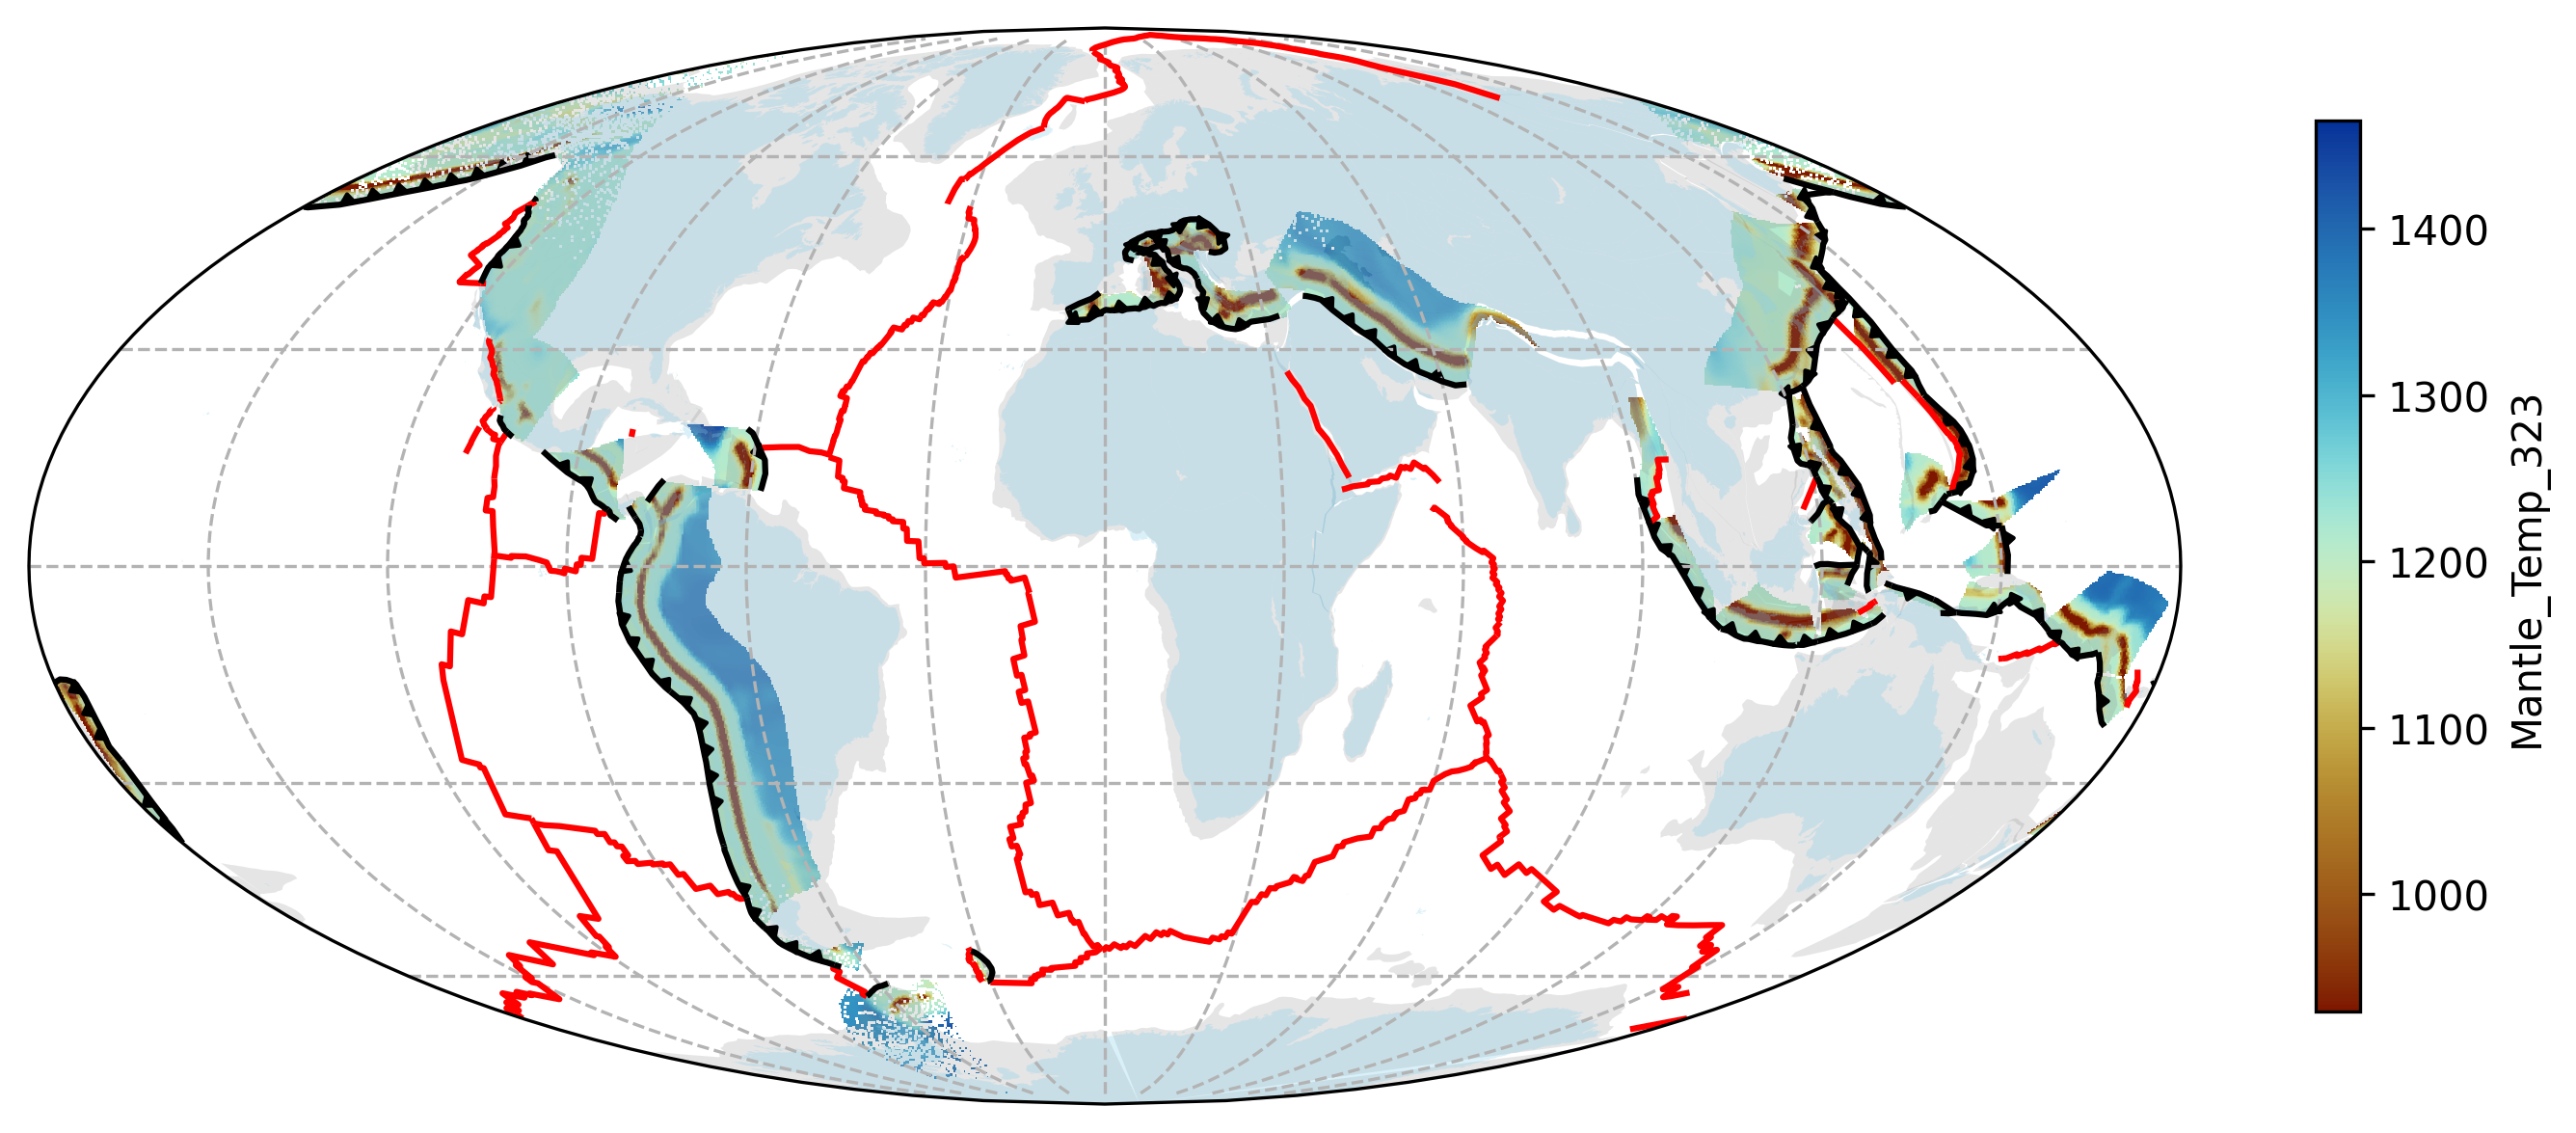

In [28]:
k=42
columns=Data_gdf.columns
column=columns[k]

data = Data_gdf[column]
# Calculate mean and standard deviation
mean = data.mean()
std = data.std()

# Calculate vmin and vmax
vmin = mean - 2 * std
vmax = mean + 2 * std
kwargs={'vmin':vmin,'vmax':vmax,'cmap':cmc.roma,'label':column}



plotgdf(Data_gdf,gplot=gplot,time=reconstruction_time,column=column,cbar=True,mollweide=True,quick=True,**kwargs)